## 1. Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import eda_helper_functions
import missingno as msno
from sklearn.ensemble import IsolationForest

## 2. Read the Training Data


In [2]:
#EDA has to be done on Training Data set. This is to avoid data leakage, data snooping.
file_path = r"C:\Users\Rahul Harshawardhan\Desktop\Flight-Price Prediction Sagemaker\data\train.csv"
train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


In [3]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [4]:
train = train.assign(**{
                 col: pd.to_datetime(train.loc[:, col], format='mixed')
                 for col in ["date_of_journey", "dep_time", "arrival_time"]
             })
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

## 3. High level summary of data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6695 non-null   object        
 1   date_of_journey  6695 non-null   datetime64[ns]
 2   source           6695 non-null   object        
 3   destination      6695 non-null   object        
 4   dep_time         6695 non-null   datetime64[ns]
 5   arrival_time     6695 non-null   datetime64[ns]
 6   duration         6695 non-null   int64         
 7   total_stops      6694 non-null   float64       
 8   additional_info  6695 non-null   object        
 9   price            6695 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 523.2+ KB


In [6]:
train.describe(include='number')

,duration,total_stops,price
count,6695.000000,6694.000000,6695.000000
mean,633.489171,0.801464,9030.965646
std,503.006311,0.659737,4639.522857
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5224.000000
50%,510.000000,1.000000,8283.000000
75%,922.500000,1.000000,12373.000000
max,2860.000000,3.000000,62427.000000


In [7]:
train.describe(include='O') # But we are considering total_stops as categorical. We will include that also.

,airline,source,destination,additional_info
count,6695,6695,6695,6695
unique,9,5,6,7
top,Jet Airways,Delhi,Cochin,No Info
freq,2391,2730,2730,5249


In [8]:
(
    train
    .assign(total_stops = train['total_stops'].astype(object))
    .describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,6695,6695,6695,6694.0,6695
unique,9,5,6,4.0,7
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,2391,2730,2730,3580.0,5249


In [9]:
# Checking the null value of total_stops
(
    train.total_stops
    .loc[lambda ser : ser.isnull()]
    #.unique()
)

2534   NaN
Name: total_stops, dtype: float64

In [10]:
train[train['total_stops'].isnull()]

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
2534,Air India,2019-05-06,Delhi,Cochin,2024-05-24 09:45:00,2024-05-24 09:25:00,1420,NaN,No Info,7480


In [11]:
train['total_stops'].unique()

array([ 1.,  0.,  2.,  3., nan])

# 4. High -level analysis of Missing Values

In [12]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,
total_stops,1,0.014937


In [13]:
train.iloc[[2534]]

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
2534,Air India,2019-05-06,Delhi,Cochin,2024-05-24 09:45:00,2024-05-24 09:25:00,1420,NaN,No Info,7480


In [14]:
train.drop(index= 2534, inplace= True, axis=1)

In [15]:
train.reset_index(inplace= True, drop= True)

# 5. High level Analysis of Outliers

In [16]:
# We can use the algorithm isolation forest. also we will make a new column in dataset indicating outliers.
forest = IsolationForest(n_estimators= 10, random_state= 42)

In [17]:
(
    train
    .assign(outlier = forest.fit_predict(train
                                        .drop(columns="price")
                                        .select_dtypes(include= "number")))
    .query("outlier == -1")
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
5,Jet Airways,2019-04-21,Banglore,Delhi,2024-05-24 18:55:00,2024-05-24 22:00:00,185,0.0,In-flight meal not included,4544,-1
7,Spicejet,2019-06-15,Mumbai,Hyderabad,2024-05-24 05:45:00,2024-05-24 07:15:00,90,0.0,No check-in baggage included,2647,-1
9,Jet Airways,2019-05-09,Delhi,Cochin,2024-05-24 23:05:00,2024-05-24 04:25:00,1760,2.0,No Info,15129,-1
10,Jet Airways,2019-06-12,Kolkata,Banglore,2024-05-24 14:05:00,2024-05-24 10:05:00,1200,1.0,No Info,13044,-1
12,Jet Airways,2019-06-24,Delhi,Cochin,2024-05-24 21:25:00,2024-05-24 19:00:00,1295,2.0,No Info,13292,-1
...,...,...,...,...,...,...,...,...,...,...,...
6686,Air India,2019-06-06,Kolkata,Banglore,2024-05-24 05:50:00,2024-05-24 08:55:00,1625,2.0,No Info,12723,-1
6687,Jet Airways,2019-06-15,Delhi,Cochin,2024-05-24 21:25:00,2024-05-24 12:35:00,910,2.0,In-flight meal not included,9905,-1
6688,Indigo,2019-03-03,Mumbai,Hyderabad,2024-05-24 09:10:00,2024-05-24 10:40:00,90,0.0,No Info,5755,-1
6689,Jet Airways,2019-03-21,Delhi,Cochin,2024-05-24 10:45:00,2024-05-24 18:50:00,1925,2.0,No Info,11093,-1


## 6. Pair Plots

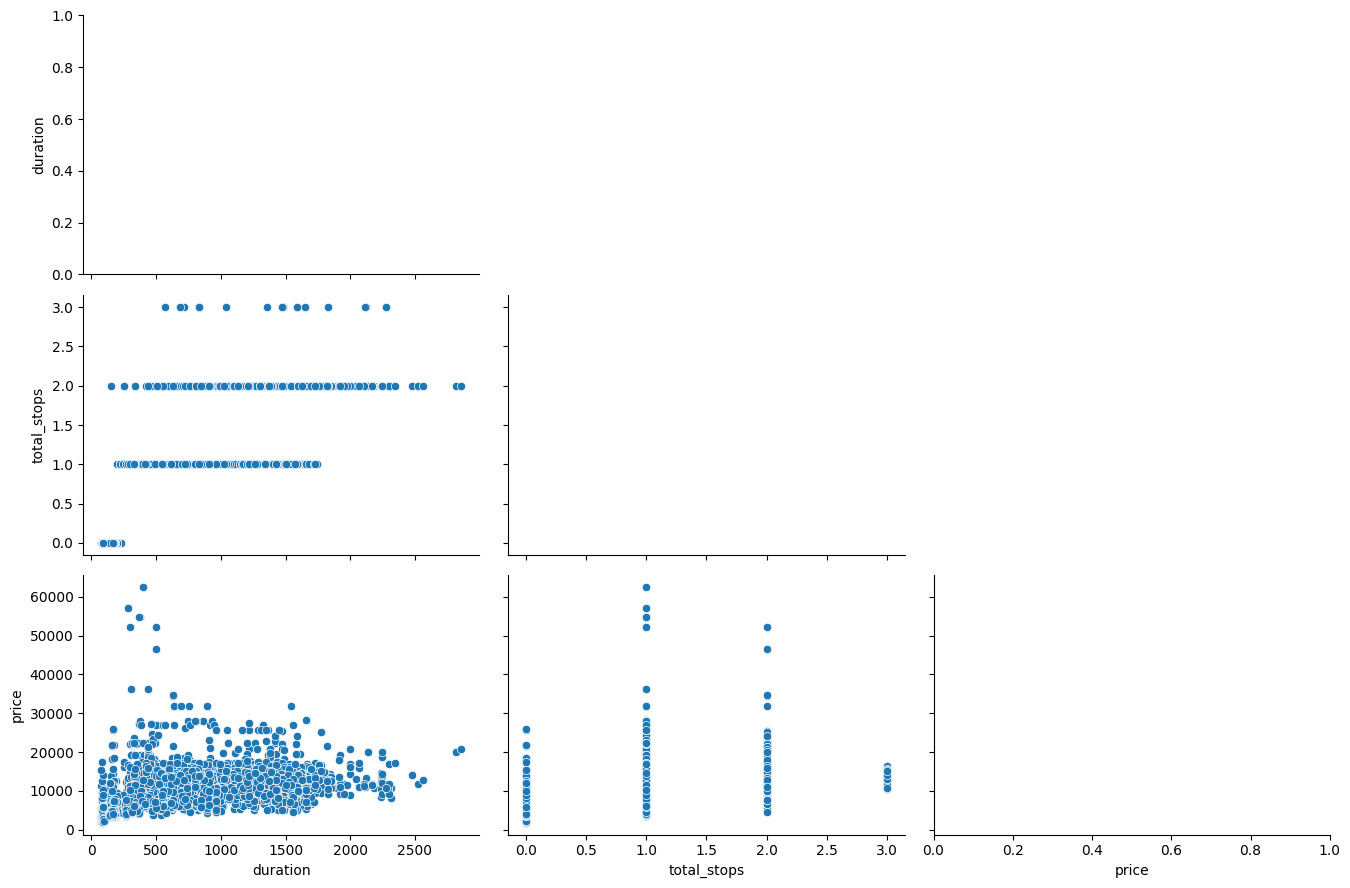

In [18]:
eda_helper_functions.pair_plots(train)

# Observations


## Left Scatter Plot: Duration vs. Price
- There seems to be a wide range of prices for flights with shorter durations (0 to 1000 minutes), with prices spanning from near 0 to over 60,000.- 
For longer durations (above 1000 minutes), the prices tend to be lower, with fewer outliers above 20,000
- There are several high-priced outliers (above 40,000) for flights with durations less than 1000 minutes.
- Most data points are clustered below 20,000 in price, regardless of duration.
There is a high density of data points for durations between 0 and 1000 minutes, indicating that most flights fall within this duration range..

## Right Scatter Plot: Total Stops vs. Price
- Prices vary across different numbers of stops, with noticeable clustering at certain stop values (e.g., 0.0, 1.0, 2.0).
- There are many flights with zero stops (non-stop flights), and their prices are spread out but mostly below 20,000.
Some high-priced outliers are also present for non-stop flights
- Flights with two stops also show a wide range of prices, though there seems to be a higher density of flights below 20,000.
- There are fewer data points for flights with three stops, but the prices appear to be mostly clustered below 20,000..

# 7. Correlation Analysis

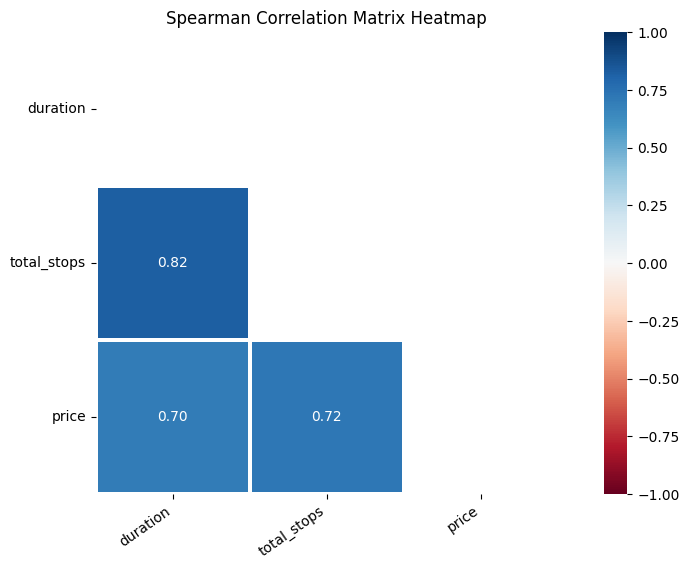

In [19]:
eda_helper_functions.correlation_heatmap(train) #Spearman correlation

# Observations

### Correlation between total_stops and duration:
- Correlation Coefficient: 0.82- 
Interpretation: There is a strong positive correlation between the number of total stops and the flight duration. As the number of stops increases, the duration of the flight also tends to increase. This makes intuitive sense because more stops usually result in longer travel times.

### Correlation between total_stops and price:
- Correlation Coefficient: 0.72- 
Interpretation: There is a strong positive correlation between the number of total stops and the flight price. As the number of stops increases, the price of the flight also tends to increase. This could be due to the additional costs associated with multiple stopovers, such as additional airport taxes and fees.


### Correlation between duration and price:
- Correlation Coefficient: 0.70- 
Interpretation: There is a strong positive correlation between flight duration and price. As the duration of the flight increases, the price of the flight also tends to increase. Longer flights often require more fuel and resources, contributing to higher costs.

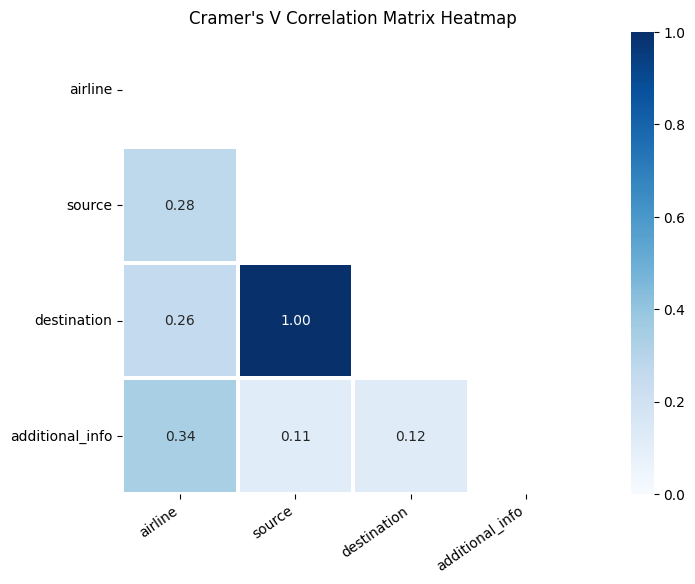

In [20]:
eda_helper_functions.cramersV_heatmap(train)# For categorical columns.

# 8. Detailed Analysis

In [21]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 airline

In [22]:
eda_helper_functions.cat_summary(train, "airline")

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6689    Jet Airways
6690      Air India
6691    Jet Airways
6692       Air Asia
6693      Air India
Name: airline, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,9
top,Jet Airways
freq,2391


,count,percentage
category,,
Jet Airways,2391,0.357186
Indigo,1296,0.193606
Air India,1075,0.160592
Multiple Carriers,736,0.109949
Spicejet,537,0.080221
Vistara,322,0.048103
Air Asia,211,0.031521
Goair,125,0.018673
Trujet,1,0.000149


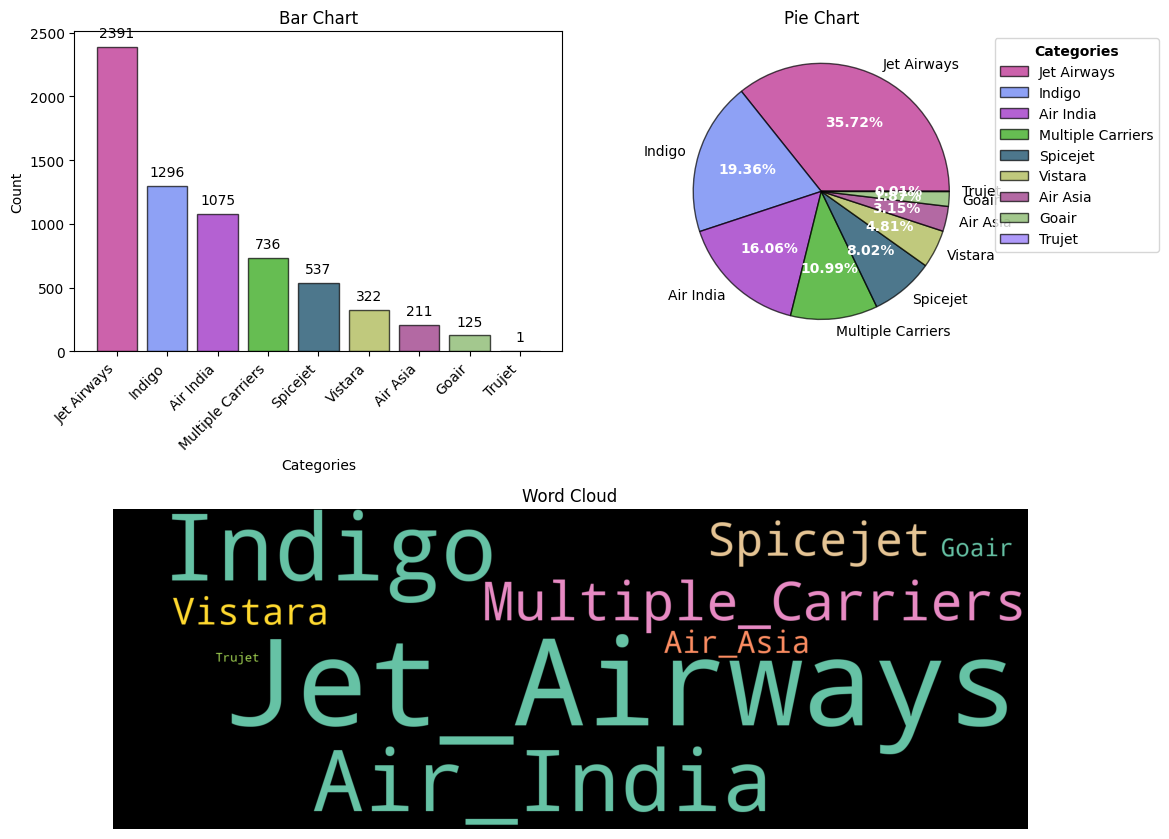

In [23]:
eda_helper_functions.cat_univar_plots(train, "airline")#show_wordcloud = False and k=3. These are the available parameter also.

In [24]:
train[train['airline'] == 'Trujet']

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
4052,Trujet,2019-03-06,Mumbai,Hyderabad,2024-05-24 13:05:00,2024-05-24 16:20:00,195,1.0,No Info,4140


In [25]:
train.drop(index= 4052, inplace= True, axis=1)
train.reset_index(inplace= True, drop= True)


### Bivariate Analysis

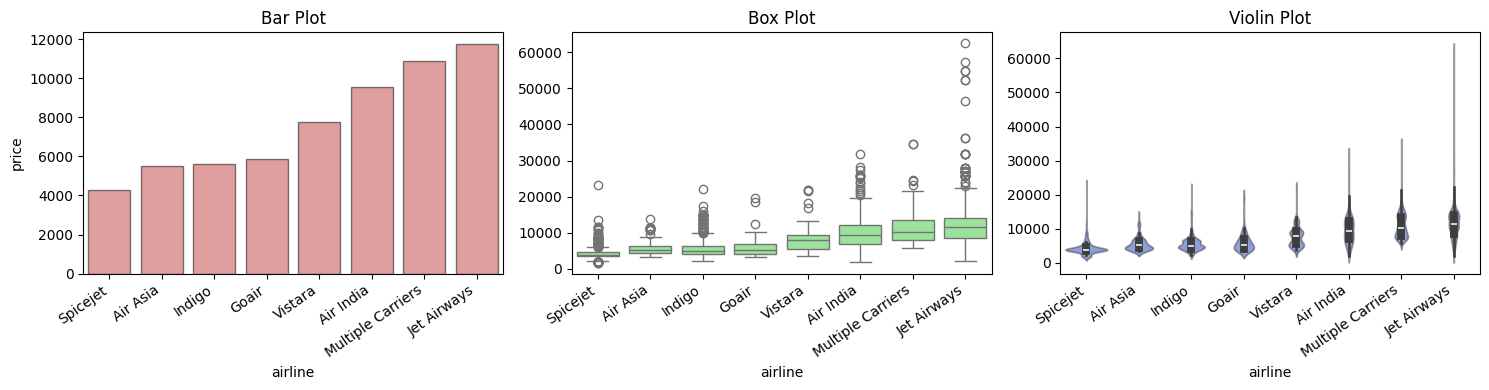

In [26]:
eda_helper_functions.num_cat_bivar_plots(
    data = train,
    num_var= "price",
    cat_var= "airline"
)

# Hypothesis Testing

In [27]:
# We saw some relationship between Airline and price. To confirm that relationship we will do hypothesis Testing.
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 540.6092392992936
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3129.4862595054738
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


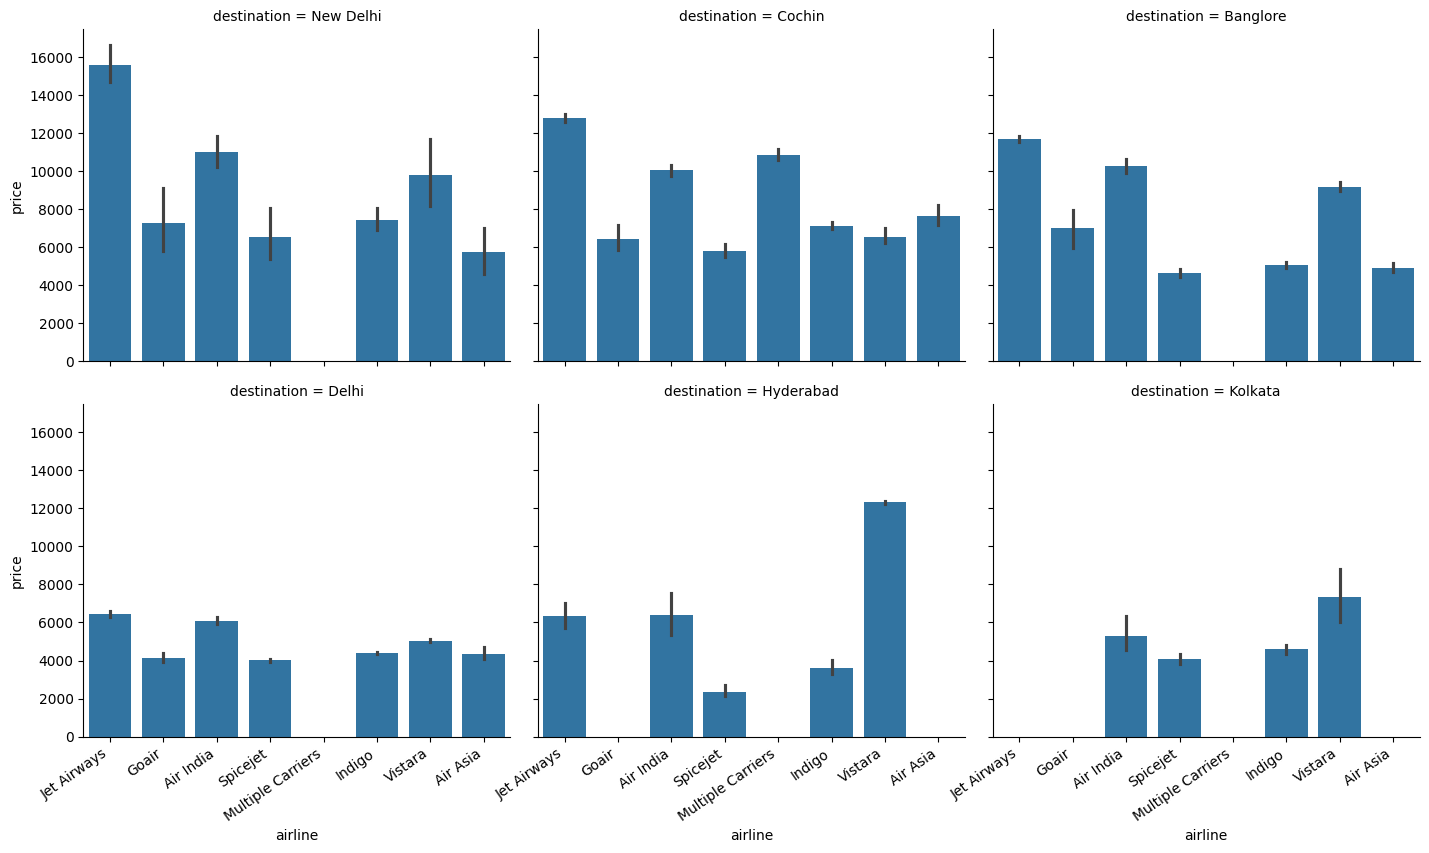

In [28]:
airline_grid = sns.FacetGrid(
    data = train,
    col = "destination",
    col_wrap = 3,
    height = 4,
    aspect= 1.2,
    sharey= True
)
airline_grid.map(sns.barplot, "airline", "price", order = train.airline.unique())

for ax in airline_grid.axes[3:]:
    eda_helper_functions.rotate_xlabels(ax)

## 8.2 Date Of Journey

In [29]:
train.date_of_journey

0      2019-03-21
1      2019-03-27
2      2019-03-09
3      2019-06-12
4      2019-03-12
          ...    
6688   2019-03-21
6689   2019-05-01
6690   2019-06-01
6691   2019-06-24
6692   2019-03-01
Name: date_of_journey, Length: 6693, dtype: datetime64[ns]

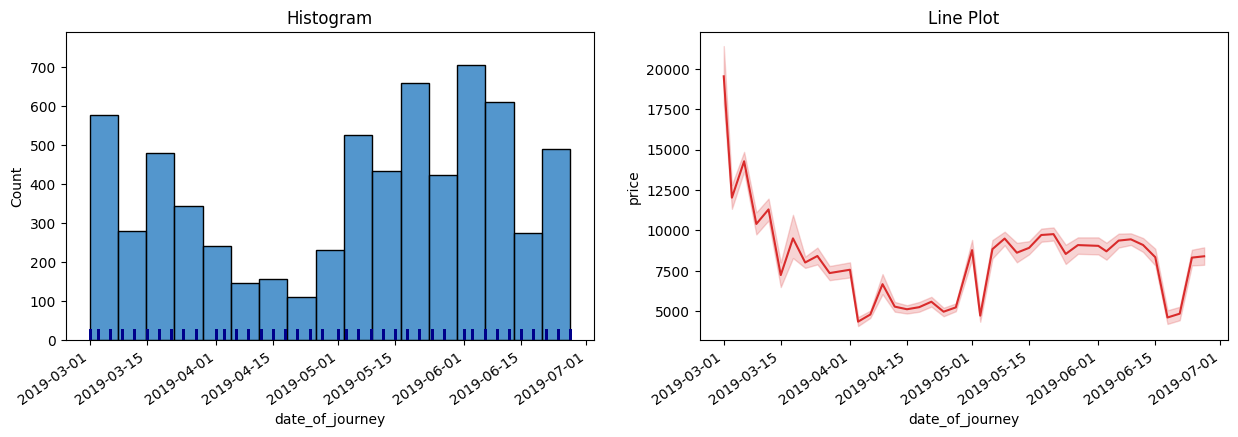

In [30]:
eda_helper_functions.dt_univar_plots(
    data = train,
    var = "date_of_journey",
    target= "price"

)

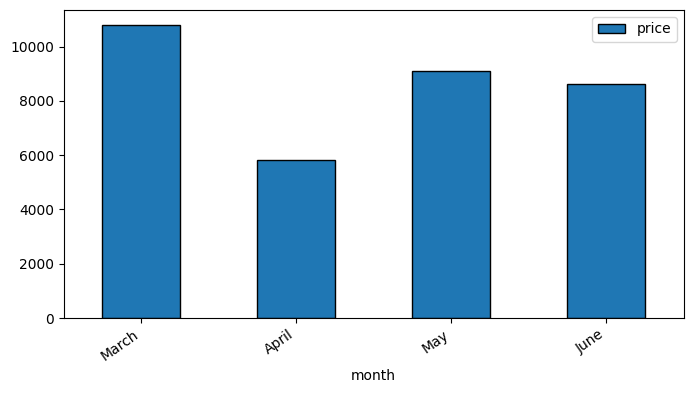

In [31]:
# I want the average price of all the months
(
    train
    .groupby(pd.Grouper(key = "date_of_journey", freq = "M"))
    .price.mean()
    .to_frame()
    .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index="month")
    .plot(
        kind = "bar",
        figsize = (8,4),
        edgecolor = "black"
    )
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

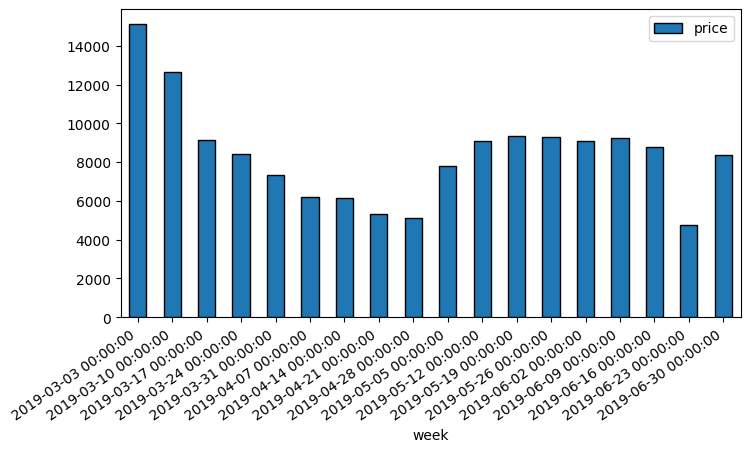

In [32]:
# I want the average price on weekly basis
(
    train
    .groupby(pd.Grouper(key = "date_of_journey", freq = "W"))
    .price.mean()
    .to_frame()
    #.set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index="week")
    .plot(
        kind = "bar",
        figsize = (8,4),
        edgecolor = "black"
    )
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

# Multivariate Analysis

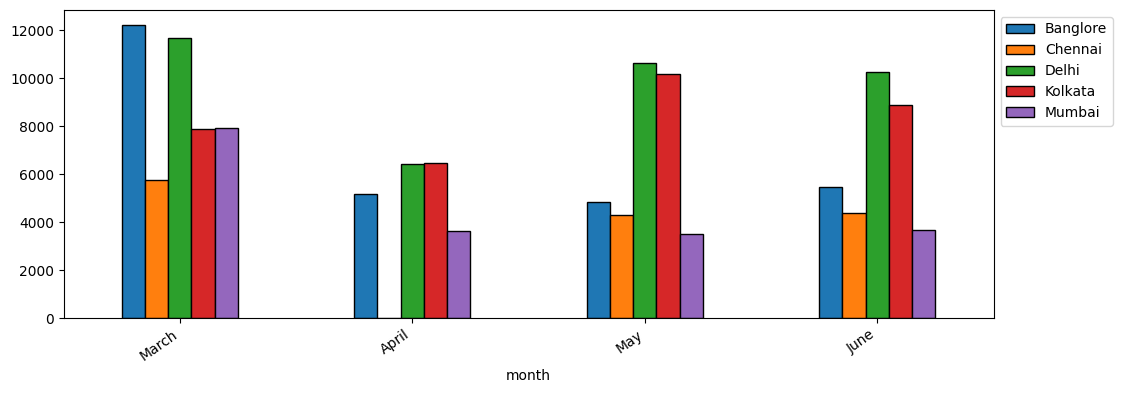

In [33]:
# Inside each month, what is the average price of each airline. for source column.

(
    train
    .groupby([pd.Grouper(key = "date_of_journey", freq="M"), "source"])
    .price.mean()
    .unstack(fill_value=0)
    .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index="month")
    .plot(
        kind = "bar",
        figsize = (12,4),
        edgecolor = "black")
)
ax = plt.gca()
ax.legend(
    loc = "upper left",
    bbox_to_anchor = (1, 1))

eda_helper_functions.rotate_xlabels(ax)


In [34]:
train.dep_time

0      2024-05-24 08:55:00
1      2024-05-24 17:30:00
2      2024-05-24 11:40:00
3      2024-05-24 09:25:00
4      2024-05-24 22:55:00
               ...        
6688   2024-05-24 10:45:00
6689   2024-05-24 09:25:00
6690   2024-05-24 14:00:00
6691   2024-05-24 07:55:00
6692   2024-05-24 11:50:00
Name: dep_time, Length: 6693, dtype: datetime64[ns]

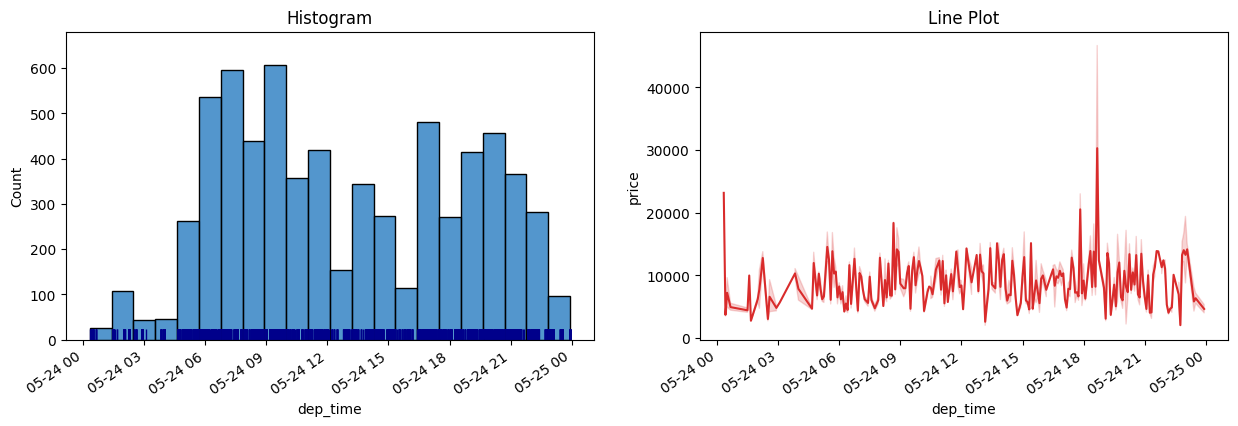

In [35]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

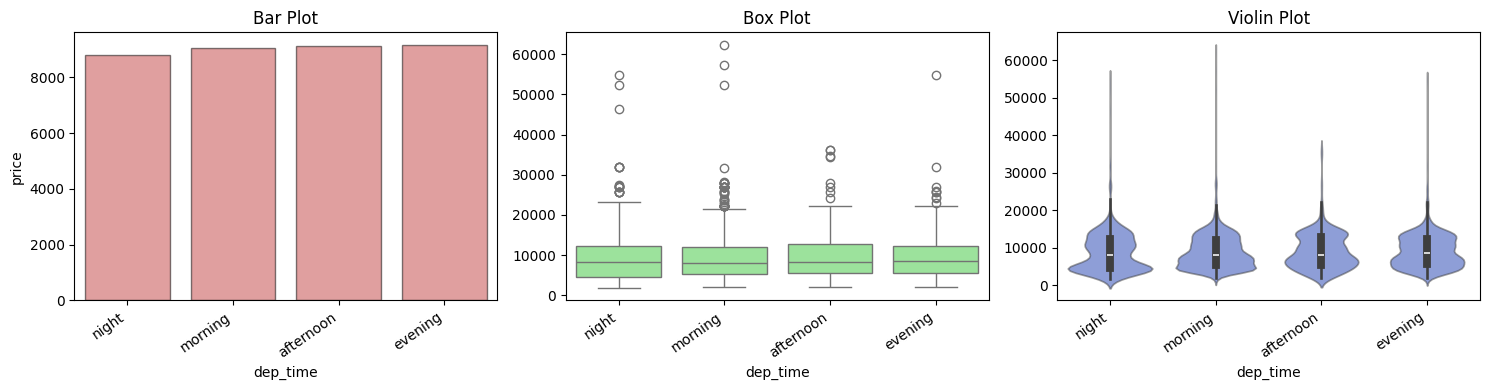

In [36]:
(
    train
    .assign(dep_time = lambda df_: (
            np.select([df_.dep_time.dt.hour.between(4, 12,inclusive="left"),
                      df_.dep_time.dt.hour.between(12, 16,inclusive="left"),
                      df_.dep_time.dt.hour.between(16, 20,inclusive="left")],
                    ["morning","afternoon","evening"],
                                  default = "night")
    ))
    .pipe(eda_helper_functions.num_cat_bivar_plots,"price", "dep_time")
    
           
)

In [37]:
# 8.4 Duration

In [38]:
train.duration

0        615
1        655
2        175
3        545
4        525
        ... 
6688    1925
6689     545
6690     300
6691     330
6692    1265
Name: duration, Length: 6693, dtype: int64

In [39]:
eda_helper_functions.num_summary(train, "duration"
                                )

0        615
1        655
2        175
3        545
4        525
        ... 
6688    1925
6689     545
6690     300
6691     330
6692    1265
Name: duration, Length: 6693, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 6,693 / 6,693 rows


,value
percentile,
0,75.0
5,90.0
10,145.0
25,170.0
50,510.0
75,920.0
90,1440.0
95,1602.0
99,1855.0


,value
mean,633.437173
trimmed mean (5%),599.642324
trimmed mean (10%),570.965453
median,510.000000


,value
var,252969.792712
std,502.961025
IQR,750.000000
mad,340.000000
coef_variance,0.794019


,value
skewness,0.893924
kurtosis,-0.052527


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 7.528309716552875e-57
Test Statistic       : 0.8865800741997679
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 248.30332446979537
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


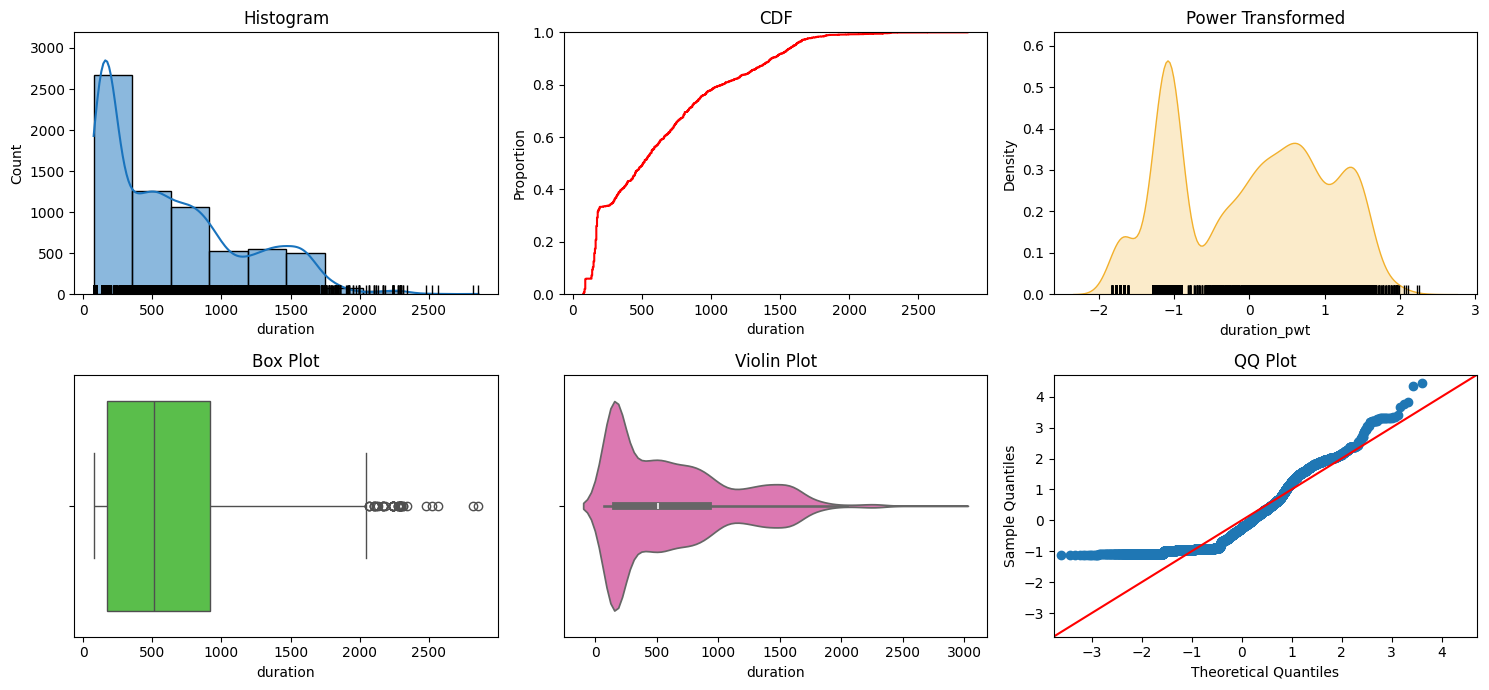

In [40]:
eda_helper_functions.num_univar_plots(train, "duration")

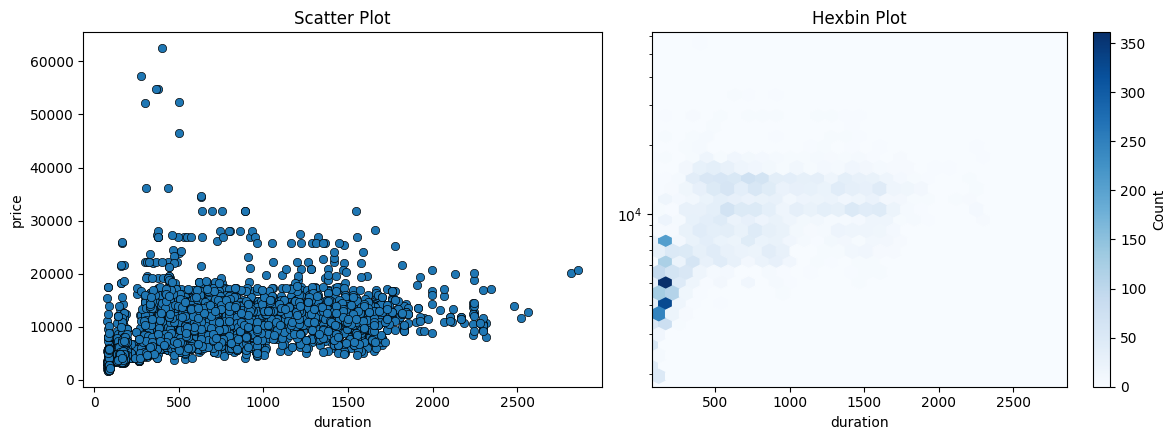

In [41]:
eda_helper_functions.num_bivar_plots(
    train,
    "duration",
    "price",
    hexbin_kwargs= dict(
        yscale = "log",
        gridsize = 30,
        cmap = "Blues"
    )
)

In [42]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5091216774257501
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6979391157274816
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


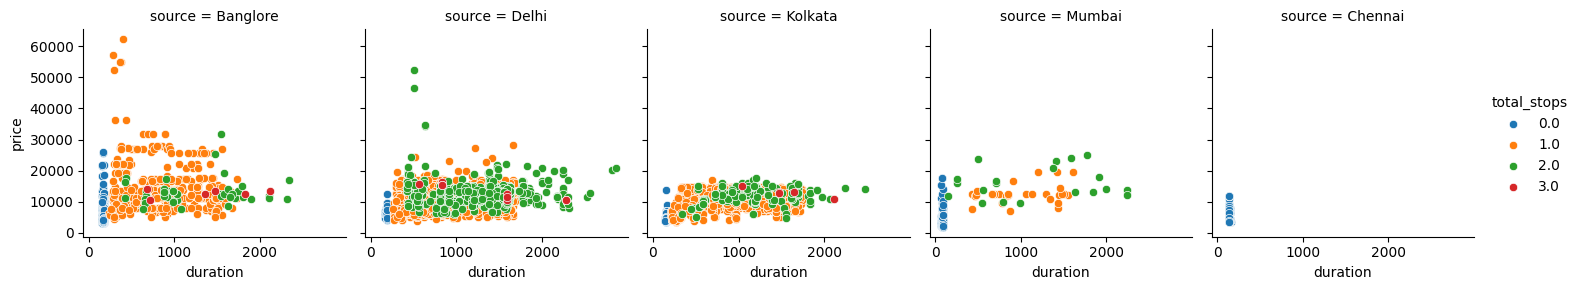

In [43]:
#Multiariate Analysis

duration_grid = sns.FacetGrid(
    data = train,
    col = "source",
    hue = "total_stops",
    sharey = True
    
)
duration_grid.map(sns.scatterplot,"duration", "price")
duration_grid.add_legend()

In [44]:
# 9. Automated EDA

In [45]:
from ydata_profiling import ProfileReport

In [46]:
profile = ProfileReport(train, title="Profiling Report")

In [47]:
profile.to_file(output_file= "output.html")

Export report to file: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [50]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -955.0
Upper Limit : 2045.0


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
3689,Air India,2019-05-01,Kolkata,Banglore,2024-05-24 05:50:00,2024-05-24 16:15:00,2065,2.0,No Info,10991
6077,Jet Airways,2019-03-06,Delhi,Cochin,2024-05-24 17:55:00,2024-05-24 04:25:00,2070,2.0,No Info,17072
3224,Jet Airways,2019-03-06,Delhi,Cochin,2024-05-24 17:55:00,2024-05-24 04:25:00,2070,2.0,In-flight meal not included,15812
2989,Air India,2019-03-03,Banglore,New Delhi,2024-05-24 11:05:00,2024-05-24 22:10:00,2105,2.0,No Info,11791
4587,Air India,2019-03-18,Banglore,New Delhi,2024-05-24 11:05:00,2024-05-24 22:10:00,2105,2.0,No Info,11161
1517,Air India,2019-03-03,Banglore,New Delhi,2024-05-24 11:05:00,2024-05-24 22:10:00,2105,2.0,No Info,11948
2915,Air India,2019-05-12,Kolkata,Banglore,2024-05-24 12:00:00,2024-05-24 23:15:00,2115,3.0,No Info,10991
2170,Air India,2019-03-12,Banglore,New Delhi,2024-05-24 06:45:00,2024-05-24 18:05:00,2120,3.0,No Info,13387
1105,Jet Airways,2019-03-06,Delhi,Cochin,2024-05-24 16:50:00,2024-05-24 04:25:00,2135,2.0,No Info,19907
3999,Air India,2019-03-06,Delhi,Cochin,2024-05-24 07:05:00,2024-05-24 19:15:00,2170,2.0,No Info,11552
